In [1]:
import os

import pandas as pd
import seaborn as sn
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from IPython.core.display import display
from pl_bolts.datamodules import CIFAR10DataModule
# from pl_bolts.transforms.dataset_normalizations import cifar10_normalization
from pytorch_lightning import LightningModule, Trainer, seed_everything, accelerators, utilities
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning.callbacks.progress import TQDMProgressBar
from pytorch_lightning.loggers import CSVLogger
from torch.optim.lr_scheduler import OneCycleLR     
from torch.optim.swa_utils import AveragedModel, update_bn
from torchmetrics.functional import accuracy
import importlib


/tmp/ipykernel_5594/1862476880.py:9: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display
/opt/conda/envs/pytorch/lib/python3.10/site-packages/pl_bolts/__init__.py:11: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, tp_name):
/opt/conda/envs/pytorch/lib/python3.10/site-packages/pl_bolts/__init__.py:11: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, tp_name):
/opt/conda/envs/pytorch/lib/python3.10/site-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:34: UnderReviewWarning: The feature generate_power_seq is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: 

In [2]:
# Reference : https://lightning.ai/docs/pytorch/stable/notebooks/lightning_examples/cifar10-baseline.html

DATA_FOLDER = "./data"
BATCH_SIZE = 512
NUM_WORKERS = int(os.cpu_count() / 2)
print(NUM_WORKERS)

4


In [3]:
from utility import cifar10Utility, imageAugmentationUtility

# import importlib
# imageAugmentationUtility = importlib.reload(imageAugmentationUtility)

train_transforms, test_transforms = imageAugmentationUtility.get_cifar10_train_and_test_transforms(cifar10Utility.get_mean(),
                                                                                                   cifar10Utility.get_std())

train_dataset, validation_dataset, test_dataset  = cifar10Utility.get_datasets(train_transforms_collection=train_transforms,
                                                                   test_transforms_collection=test_transforms,
                                                                    data_folder=DATA_FOLDER)
print(f"Images in train_dataset are :{len(train_dataset)}, validation_dataset: {len(validation_dataset)}, and test_dataset: {len(test_dataset)}")
train_loader, validation_loader, test_loader = cifar10Utility.get_dataloaders(train_dataset=train_dataset,
                                                                    validation_dataset=validation_dataset,
                                                                    test_dataset=test_dataset,
                                                                    num_workers=NUM_WORKERS,
                                                                    batch_size=BATCH_SIZE)
print(f"Batches count in train data loader are :{len(train_loader)}, validation loader: {len(validation_loader)},and test data loader: {len(test_loader)}")


Files already downloaded and verified
Files already downloaded and verified
Images in train_dataset are :40000, validation_dataset: 10000, and test_dataset: 10000
Shape of test_dataloader batch_data [Batch, C, H, W]: torch.Size([512, 3, 32, 32])
Shape of test_dataloader label (label): torch.Size([512]) torch.int64
Batches count in train data loader are :79, validation loader: 20,and test data loader: 20


Total number of batches: 79, batch_size : 512), selected batch_index: 50


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


['plane', 'car', 'cat', 'car', 'bird', 'horse', 'truck', 'deer']


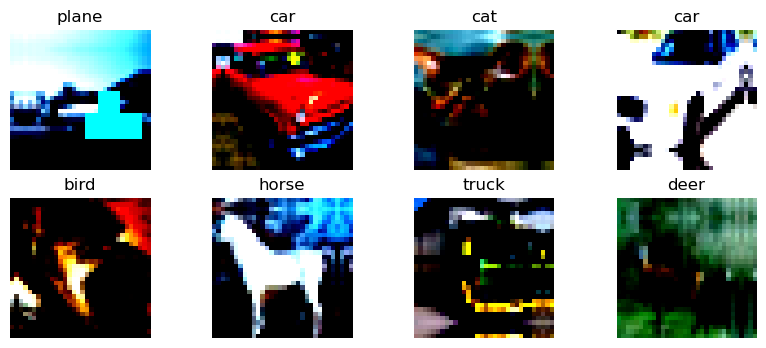

In [4]:
from utility import commonUtility
from utility import imageVisualizationUtility

# get some random training images
images, labels = commonUtility.get_random_images_from_data_loader(train_loader, images_count=8)
labels = cifar10Utility.get_labels_names(labels_indexes=labels)
print(labels)
imageVisualizationUtility.show(images, labels)

# show images using torch vision grid function
# imageVisualizationUtility.show(torchvision.utils.make_grid(images), labels="-".join(labels))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


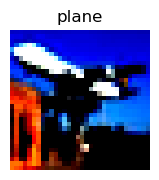

In [5]:
# Print single image from test dataset
import random
image, label = test_dataset[random.randint(0,len(test_dataset)-1)]
label = cifar10Utility.get_labels_names(labels_indexes=label)
imageVisualizationUtility.show(image, label)

In [9]:
# Modify the pre-existing Resnet architecture from TorchVision. 
# The pre-existing architecture is based on ImageNet images (224x224) as input.
# So we need to modify it for CIFAR10 images (32x32).
def create_model():
    model = torchvision.models.resnet18(num_classes=10)
    model.conv1 = nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    model.maxpool = nn.Identity()
    return model


In [10]:
import torchmetrics
import torchmetrics.classification


class LightResnet(LightningModule):
    def __init__(self, lr=0.002):
        super().__init__()

        self.save_hyperparameters()
        self.model = create_model()
        self.train_acc = torchmetrics.classification.Accuracy(task="multiclass", num_classes=10)
        self.test_acc = torchmetrics.classification.Accuracy(task="multiclass", num_classes=10)
        self.valid_acc = torchmetrics.classification.Accuracy(task="multiclass", num_classes=10)

    def forward(self, x):
        out = self.model(x)
        return F.log_softmax(out, dim=1)

    def training_step(self, batch, batch_idx):
        inputs, labels = batch
        predictions = self(inputs)
        loss = F.nll_loss(predictions, labels)
        # logs metrics for each training_step,
        # and the average across the epoch, to the progress bar and logger
        self.train_acc(predictions, labels)
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log('train_acc', self.train_acc, on_step=True, on_epoch=True, prog_bar=True, logger=True )
        return loss
    
    def validation_step(self, batch, batch_idx):
        inputs, labels = batch
        output = self(inputs)
        loss = F.nll_loss(output, labels)
        preds = torch.argmax(output, dim=1)
        self.valid_acc(preds, labels)
        self.log(f"valid_loss", loss, on_step=False, on_epoch=True, prog_bar=False, logger=True)
        self.log('valid_acc', self.valid_acc, on_step=False, on_epoch=True, prog_bar=False, logger=True)


    def test_step(self, batch, batch_idx):
        inputs, labels = batch
        output = self(inputs)
        loss = F.nll_loss(output, labels)
        preds = torch.argmax(output, dim=1)
        self.test_acc(preds, labels)
        self.log(f"test_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log('test_acc', self.test_acc, on_step=False, on_epoch=True, prog_bar=True, logger=True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.lr, weight_decay=1e-4)
        steps_per_epoch = len(train_loader)// BATCH_SIZE
        scheduler_dict = {
            "scheduler": OneCycleLR(
                optimizer,
                0.1,
                total_steps=self.trainer.estimated_stepping_batches,
                steps_per_epoch=steps_per_epoch,
            ),
            "interval": "step",
        }
        return {"optimizer": optimizer, "lr_scheduler": scheduler_dict}

In [11]:
model = LightResnet()
utilities.model_summary.ModelSummary(model, max_depth=2)

   | Name          | Type               | Params
------------------------------------------------------
0  | model         | ResNet             | 11.2 M
1  | model.conv1   | Conv2d             | 1.7 K 
2  | model.bn1     | BatchNorm2d        | 128   
3  | model.relu    | ReLU               | 0     
4  | model.maxpool | Identity           | 0     
5  | model.layer1  | Sequential         | 147 K 
6  | model.layer2  | Sequential         | 525 K 
7  | model.layer3  | Sequential         | 2.1 M 
8  | model.layer4  | Sequential         | 8.4 M 
9  | model.avgpool | AdaptiveAvgPool2d  | 0     
10 | model.fc      | Linear             | 5.1 K 
11 | train_acc     | MulticlassAccuracy | 0     
12 | test_acc      | MulticlassAccuracy | 0     
13 | valid_acc     | MulticlassAccuracy | 0     
------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.696    Total estimated model params size (MB)

In [12]:
# from lightning.pytorch.callbacks import LearningRateFinder
# class FineTuneLearningRateFinder(LearningRateFinder):
#     def __init__(self, milestones, *args, **kwargs):
#         super().__init__(*args, **kwargs)
#         self.milestones = milestones

#     def on_fit_start(self, *args, **kwargs):
#         print("On fit started")
        

#     def on_train_epoch_start(self, trainer, pl_module):
#         if trainer.current_epoch in self.milestones or trainer.current_epoch == 0:
#             print(f"on_train_epoch_start : {trainer.current_epoch}")
#             self.lr_find(trainer, pl_module)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loading `train_dataloader` to estimate number of stepping batches.


Finding best initial lr:   0%|          | 0/200 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
Restoring states from the checkpoint path at /home/ec2-user/my/erav3-assignment-13/.lr_find_b4fa21d9-8865-4891-a63c-1c028c72cefc.ckpt
Restored all states from the checkpoint file at /home/ec2-user/my/erav3-assignment-13/.lr_find_b4fa21d9-8865-4891-a63c-1c028c72cefc.ckpt


Suggested LR: 0.000630957344480193


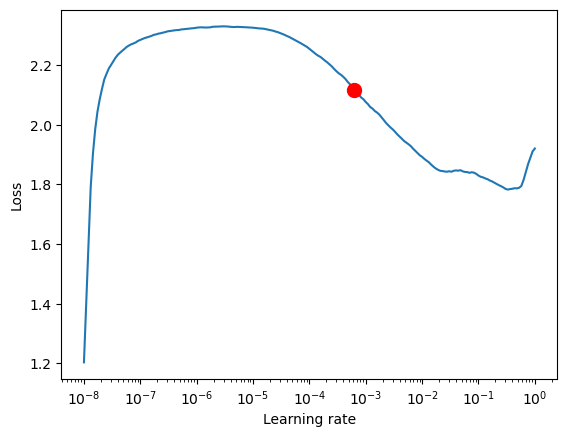

In [14]:
from lightning.pytorch.loggers import TensorBoardLogger

trainer = Trainer(
    max_epochs=30,
    accelerator="auto",
    devices=1 if torch.cuda.is_available() else None,  # limiting got iPython runs
    logger=CSVLogger(save_dir="logs/"), #[TensorBoardLogger(save_dir="logs/"), CSVLogger(save_dir="logs/")],
    auto_lr_find=True,
    callbacks=[LearningRateMonitor(logging_interval="step"), TQDMProgressBar(refresh_rate=10)]
)

# Find the learning rate
# result = trainer.tune(model, train_loader)
lr_finder = trainer.tuner.lr_find(model, train_loader, validation_loader, num_training=200)
new_lr = lr_finder.suggestion()
print(f"Suggested LR: {new_lr}")
fig = lr_finder.plot(suggest=True)
fig.show()

In [15]:
# Setting new learning rate
model.hparams.lr = new_lr
trainer.fit(model, train_loader, validation_loader)
trainer.test(model, test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loading `train_dataloader` to estimate number of stepping batches.

  | Name      | Type               | Params
-------------------------------------------------
0 | model     | ResNet             | 11.2 M
1 | train_acc | MulticlassAccuracy | 0     
2 | test_acc  | MulticlassAccuracy | 0     
3 | valid_acc | MulticlassAccuracy | 0     
-------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.696    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.7505000233650208     │
│         test_loss         │    0.7100269794464111     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.7100269794464111, 'test_acc': 0.7505000233650208}]

logs/lightning_logs/version_2/metrics.csv


,lr-Adam,train_loss_step,train_acc_step,valid_acc,train_loss_epoch,train_acc_epoch,test_loss,test_acc
epoch,,,,,,,,
NaN,0.005124,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.0,NaN,1.604564,0.412109,NaN,NaN,NaN,NaN,NaN
0.0,NaN,NaN,NaN,0.3853,NaN,NaN,NaN,NaN
0.0,NaN,NaN,NaN,NaN,1.863685,0.317850,NaN,NaN
NaN,0.008532,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
NaN,0.000036,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29.0,NaN,0.765859,0.708984,NaN,NaN,NaN,NaN,NaN
29.0,NaN,NaN,NaN,0.7166,NaN,NaN,NaN,NaN


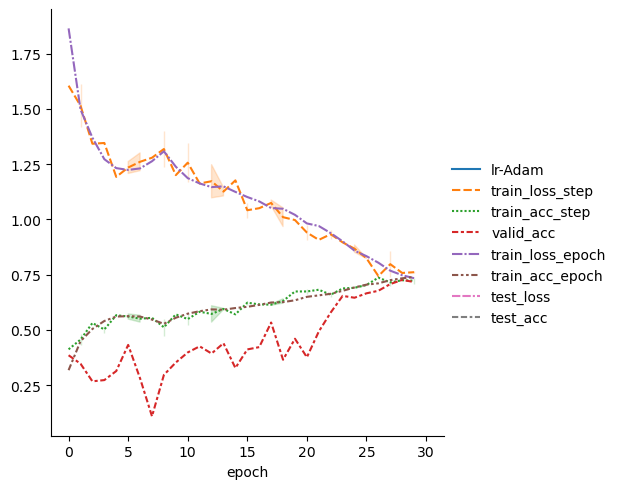

In [17]:
print(f"{trainer.logger.log_dir}/metrics.csv")
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")

del metrics["step"]
del metrics["valid_loss"]
metrics.set_index("epoch", inplace=True)
display(metrics.dropna(axis=1, how="all"))
sn.relplot(data=metrics, kind="line")

In [18]:
# Saving model 
torch.save(model.state_dict(), f"{trainer.logger.log_dir}/lightning_resnet18.pth")

In [19]:
# Creating new model instance and loading weights
new_loaded_model = LightResnet()
new_loaded_model.load_state_dict(torch.load(f"{trainer.logger.log_dir}/lightning_resnet18.pth"))
utilities.model_summary.ModelSummary(new_loaded_model, max_depth=2)
# Set the model to evaluation mode (disable dropout, randomness, etc.)
new_loaded_model = new_loaded_model.eval()

In [20]:

batch_images, batch_labels = commonUtility.get_random_images_batch_and_labels_from_data_loader(test_loader)

#  {"images" : images, "predicted_labels" : predicted_labels, "actual_labels" : actual_labels}
non_matched_results, matched_results = commonUtility.get_images_for_matched_and_non_matched_model_predictions(new_loaded_model, batch_images, batch_labels, max_image_count=10)

Total number of batches: 20, batch_size : 512), selected batch_index: 15
matched_indices: 377
non_matched_indices: 135


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

For Matched results


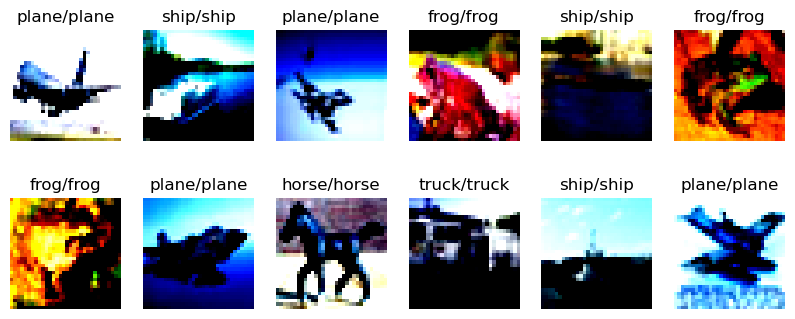

In [21]:
print("For Matched results")
predicted_labels_names = cifar10Utility.get_labels_names(labels_indexes=matched_results["predicted_labels"])
actual_labels_names = cifar10Utility.get_labels_names(labels_indexes=matched_results["actual_labels"])
matched_combined_labels = commonUtility.combine_labels(predicted_labels_names, actual_labels_names)
imageVisualizationUtility.show(matched_results["images"], matched_combined_labels)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


For Non-Matched results


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


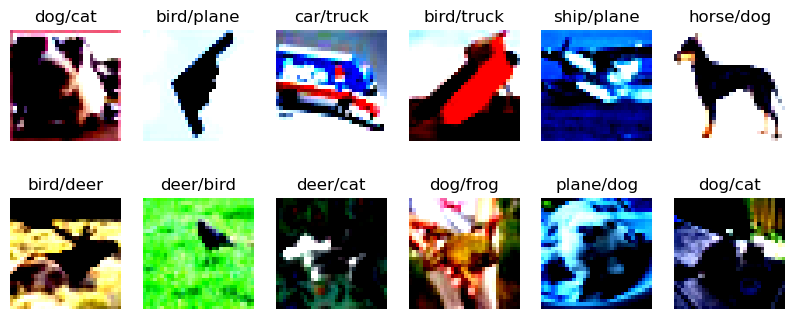

In [22]:
print("For Non-Matched results")
predicted_labels_names = cifar10Utility.get_labels_names(labels_indexes=non_matched_results["predicted_labels"])
actual_labels_names = cifar10Utility.get_labels_names(labels_indexes=non_matched_results["actual_labels"])
non_matched_combined_labels = commonUtility.combine_labels(predicted_labels_names, actual_labels_names)
imageVisualizationUtility.show(non_matched_results["images"], non_matched_combined_labels)

For Matched results


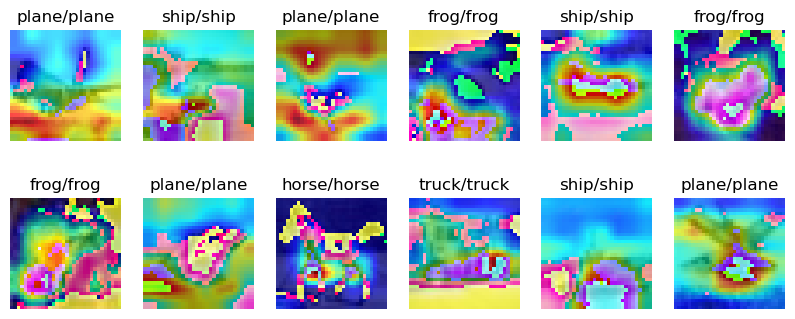

In [40]:
from utility import gradcamUtility

print("For Matched results")
# param image_weight: The final result is image_weight * img + (1-image_weight) * mask
heatmap_overlaid_images = gradcamUtility.create_grad_cam_overlaid_images(new_loaded_model.model, 
                                                                         [new_loaded_model.model.layer3[-1]],
                                                                         images=matched_results["images"],
                                                                         predictions_labels=matched_results["predicted_labels"],
                                                                         actual_labels=matched_results["actual_labels"],
                                                                         image_weight=0.98
                                                                         )
imageVisualizationUtility.show(heatmap_overlaid_images, matched_combined_labels)

For Non-Matched results


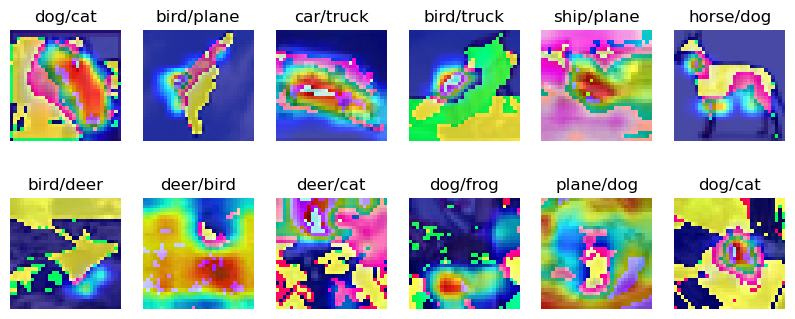

In [44]:
print("For Non-Matched results")
# param image_weight: The final result is image_weight * img + (1-image_weight) * mask
heatmap_overlaid_images = gradcamUtility.create_grad_cam_overlaid_images(new_loaded_model.model, 
                                                                         [new_loaded_model.model.layer3[-1]],
                                                                         images=non_matched_results["images"],
                                                                         predictions_labels=non_matched_results["predicted_labels"],
                                                                         actual_labels=non_matched_results["actual_labels"],
                                                                         image_weight = 0.98
                                                                         )
imageVisualizationUtility.show(heatmap_overlaid_images, non_matched_combined_labels)